# Hybrid Metaheuristics <br> for Last-mile Delivery Scheduling and Rescheduling

**Authors:** Weixuan Yang, Qin Deng, Hanyu Xi<br>
**Contact:** {weixuan.yang, davy.deng, hanyuxi}@mail.utoronto.ca<br>
**Course:** ECE1724H: Bio-inspired Algorithms for Smart Mobility - Fall 2021<br>
**Instructor:** Dr. Alaa Khamis<br>
**Department:** The Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto

<br>**[Notice] Please check the critical dependencies at the bottom of this notebook.**

In [1]:
from watermark import watermark
print(watermark())

Last updated: 2022-12-15T22:49:54.631745-05:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



## Introduction

The last mile delivery scheduling and rescheduling problem is also known as Vehicle Routing Problem with Time Window (VRPTW). In VRPTW, many packages will be delivered by several vehicles. Each package should be delivered within a time window to meet customers’ demands. The capacity limit and maximum work time of each vehicle should also be considered. If the scheduled delivery for any package failed, a second attempt is scheduled on the same day if possible.

In [2]:
%matplotlib inline
import json
import random
import osmnx
import folium
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import numpy as np
import warnings
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from smart_mobility_utilities.common import random_tour
from smart_mobility_utilities.problem import PMX_crossover, insert_mutation
from tqdm.notebook import tqdm
from seaborn import scatterplot, color_palette
from concurrent.futures import ThreadPoolExecutor, as_completed
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dataset

The data set we use is from 2021 Amazon Last Mile Routing Research Challenge Dataset: https://registry.opendata.aws/amazon-last-mile-challenges/. We choose one route data in Orange, CA, USA, which contains 157 packages and 1 depot. The data set also contains package volume, time window, location and travel time between each two locations.


In [3]:
raw_data = pd.read_csv('data\DLA7_package_data.csv', index_col=[0])
package_data = pd.DataFrame(columns=['loc_lat','loc_lng','dim_depth_cm','dim_height_cm','dim_width_cm','tim_start','tim_end','tim_plan_sec'])
loc_data = pd.read_csv('data\DLA7_stop_data.csv', index_col=[0])
for index, row in raw_data.iterrows():
    if index not in loc_data.index:
        continue
    for column in row[row.notna()]:
        if column == "{}":
            continue
        column = json.loads(column.replace("'", '"').replace("nan",'"nan"'))
        for id in column.keys():
            package = pd.DataFrame(data=[{"label": index,
                    'loc_lat': loc_data.loc[index,'lat'],
                    'loc_lng': loc_data.loc[index,'lng'],
                    'dim_depth_cm': column[id]['dimensions']['depth_cm'],
                    'dim_height_cm': column[id]['dimensions']['height_cm'],
                    'dim_width_cm': column[id]['dimensions']['width_cm'],
                    'volume': column[id]['dimensions']['depth_cm']*column[id]['dimensions']['height_cm']*column[id]['dimensions']['width_cm'],
                    'tim_start': column[id]['time_window']['start_time_utc'],
                    'tim_end': column[id]['time_window']['end_time_utc'],
                    'tim_plan_sec': column[id]['planned_service_time_seconds']}], index=[id.replace('PackageID_','')])
        package_data = package_data.append(package)
package_data.index.name = 'id'
package_data.head()

,loc_lat,loc_lng,dim_depth_cm,dim_height_cm,dim_width_cm,tim_start,tim_end,tim_plan_sec,label,volume
id,,,,,,,,,,
b4602d93-e3e0-4aab-909a-bed9b8829850,33.785869,-117.802461,49.5,7.6,35.6,nan,nan,49.0,AU,13392.720
1f3eb06c-1dd1-4a4e-912d-b334b2504f61,33.786393,-117.825913,34.3,11.4,20.3,nan,nan,59.0,AV,7937.706
e9a647b0-0194-4a31-9110-0ad4e324cefb,33.784522,-117.816622,43.2,7.6,27.9,nan,nan,90.0,AY,9160.128
3114e839-d0d0-417f-8016-8a80bd96a3fa,33.788544,-117.827046,25.4,12.7,17.8,2018-07-26 16:00:00,2018-07-26 23:00:00,430.0,CM,5741.924
16a25f79-40fe-470d-b54a-c53caca0b955,33.784569,-117.817442,31.0,2.0,28.4,nan,nan,52.0,FQ,1760.800


Furthermore, a dataframe named "time_data" is loaded to store the travelling time through the on-route depot and drop-off locations.

In [4]:
time_data = pd.read_csv('data\DLA7_travel_data.csv', index_col=[0]).dropna(axis=1)
time_data.head()

,AU,AV,AY,CM,FQ,GO,GR,GY,HQ,IP,...,NX,CN,FJ,GX,HZ,NO,RY,TJ,VI,XL
AG,225.9,202.0,165.4,210.8,155.5,235.6,314.4,320.0,223.4,72.0,...,172.3,108.9,2169.1,224.9,135.6,151.0,305.3,277.0,279.2,94.7
AI,299.1,297.7,170.1,280.6,180.0,107.0,208.2,191.2,220.4,214.7,...,45.5,174.8,2256.9,302.6,196.2,184.8,181.1,229.8,270.7,186.8
AM,260.9,405.4,212.9,371.5,222.8,160.7,299.1,282.1,169.1,257.4,...,97.4,217.6,2313.2,355.4,242.4,275.7,272.0,320.7,361.6,248.5
AT,495.4,164.9,250.4,183.5,240.5,229.2,63.1,139.4,411.4,344.1,...,236.5,273.3,2159.8,388.2,298.1,270.4,99.0,207.4,153.8,304.2
AU,0.0,389.9,353.3,398.7,342.6,423.5,502.3,402.4,162.6,215.6,...,360.2,296.8,2107.2,337.8,323.5,338.9,493.2,464.9,467.1,273.5


A function that used to find the travel times between any two points from the "time_data" dataframe loaded before is implemented.

In [5]:
def get_travel_time(a, b):
  try:
    travel_time = time_data.loc[a, b]
  except:
    travel_time = time_data.loc[b, a]
  if pd.isna(travel_time):
    raise ValueError('Starting point and destination pair does not exist.')
  return travel_time

The 157 packages (blue marker) and one depot (red marker) can be found in the following graphs.

In [6]:
depot = [33.965477, -117.653303] # DLA7 amazon warehouse
customer_map = folium.Map(location=depot, zoom_start=10)
location_list = package_data[['loc_lat', 'loc_lng']].values.tolist()
for point in range(0, len(location_list)):
    folium.Marker(location_list[point], popup=folium.Popup(str(point))).add_to(customer_map)
folium.Marker(depot, icon=folium.Icon(color="red", icon="info-sign")).add_to(customer_map)
customer_map

The figure below demonstrates the distribution of the drop-off locations around the designated city blcok.

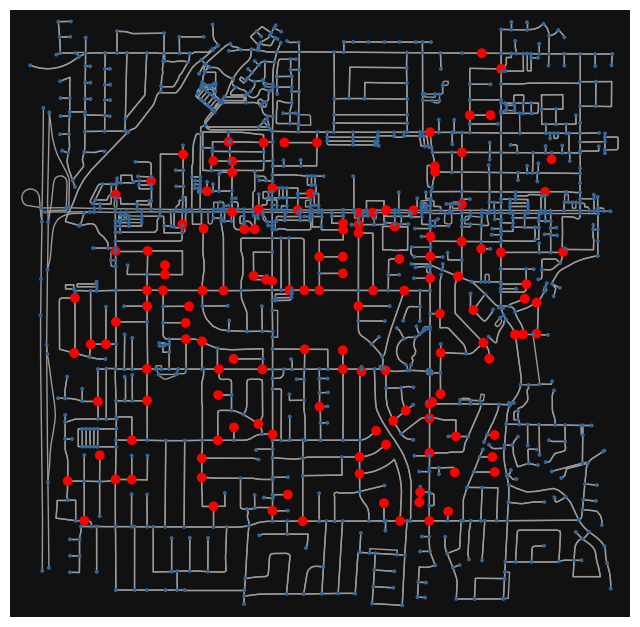

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [7]:
X = [l[0] for l in location_list]
Y = [l[1] for l in location_list]
center = (sum(X)/len(X), sum(Y)/len(Y))
graph = osmnx.graph_from_point(center, dist=1500)
nodes, edges = osmnx.graph_to_gdfs(graph)
closest_nodes = osmnx.distance.nearest_nodes(graph,Y,X)
nc = ['red' if node in closest_nodes else '#336699' for node in graph.nodes()]
ns = [50 if node in closest_nodes else 8 for node in graph.nodes()]
osmnx.plot_graph(graph, node_size=ns, node_color=nc, node_zorder=2)

## Problem Formulation

### Variables

$V$: the set of nodes including packages ($V_D=\{0, n+1\}$) and depots ($V_C=\{1,2,...,n\}$)<br>
$d_{ij}$: the distance between node i and node j<br>
$t_{ij}$: the travle time between node i and node j<br>
$x_{ijk}$: whether the $V_j$ is visited after $V_i$  by vehicle k. True->1, False->0 <br>
$q_i$: the volume of package i<br>
$Q$: the volume limit of each vehicle <br>
$e_i$: the start time of node i's time window<br>
$l_i$: the end time of node i's time window<br>
$e_{ik}$: the earliness at drop-off location i served by vehicle k
$l_{ik}$: the lateness at drop-off location i served by vehicle k
$h_i$: the service time of node i<br>
$s_{ik}$: the time that vehicle k reached the node i<br>
$c$: the cost paid for one meter in the distance<br>
$epu$: the penalty cost per second for arriving early<br>
$lpu$: the penalty cost per second for arriving lately<br>

### Objective

$min \; c\sum_{k \in K}\sum_{i \in V}\sum_{j \in V}d_{ij} x_{ijk} + epu \sum_{k \in K} \sum_{i \in V_c} e_{ik} + lpu \sum_{k \in K} \sum_{i \in V_c} l_{ik}$ <br>

The objective function is to minimize the traveling costs of routes and the penalty costs of early or late delivery.

### Constraints

$\sum_{j \in V} \sum_{k \in K} x_{ijk} = 1 $  (exactly one vehicle arrives at each customer location)<br>
$\sum_{i \in V} x_{imk} - \sum_{j \in V} x_{mjk} = 0 $  (the vehicle that arrives at one location must leave it)<br>
$\sum_{i \in V_c} q_i \sum_{j \in V} x_{ijk} <= Q $  (the vehicle capacity should not be exceeded)<br>
$\sum_{j \in V_c} x_{0jk} = 1 $  (each vehicle starts at depot)<br>
$\sum_{i \in V_c} x_{i,n+1,k} = 1 $  (each vehicle ends at depot)<br>
$s_{ik}+h_i+t_{ij}=s_{jk}$  (the relationship between the visit time of a location and its successor)<br>
$e_{ik}=max(e_i-s_{ik},0)$  (the earliness of a drop-off location)<br>
$l_{ik}=max(s_{ik}-l_i,0)$  (the earliness of a drop-off location)<br>

### Fitness$_{[1]}$

To implement the optimization algorithms considering all the constraints intuitively, we use the reciprocal of the traveling cost as fitness that to be maximized inside the  optimizers. Furthermore, since some constraints are not needed to be considered when the package data is preprocessed into routes, a simpler version of the fitness functions "*_multi" are also implemented as "*_single". The fitness function class is defined as follows:


In [8]:
class FitnessFunc:
    def __init__(self, df_package, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code):
        self.package_data = df_package
        self.unit_cost = unit_cost
        self.wait_cost = wait_cost
        self.delay_cost = delay_cost
        self.vehicle_capacity = vehicle_capacity
        self.work_time = work_time
        self.depot = depot_code
    def assign_route_multi(self, individual):
        # transform a list of customer/package id to several routes that meet the capacity limit and time window
        this_route = []
        sub_route = []
        vehicle_load = 0
        elapsed_time = 0
        last_customer_id = -1
        for customer_id in individual:
            # Update vehicle load
            demand = self.package_data.iloc[customer_id].volume
            updated_vehicle_load = vehicle_load + demand
            # Update elapsed time
            service_time = self.package_data.iloc[customer_id].tim_plan_sec
            return_time = get_travel_time(self.package_data.iloc[customer_id].label, self.depot)
            if last_customer_id != -1:
                updated_elapsed_time = elapsed_time + \
                    get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)+ service_time
            else:
                updated_elapsed_time = get_travel_time(self.depot, self.package_data.iloc[customer_id].label) + service_time + return_time
            # Validate vehicle load and elapsed time
            if (updated_vehicle_load <= self.vehicle_capacity) and (updated_elapsed_time <= self.work_time):
                # Add to current sub-route
                sub_route.append(customer_id)
                vehicle_load = updated_vehicle_load
                elapsed_time = updated_elapsed_time-return_time
            else:
                # Save current sub-route
                this_route.append(sub_route)
                # Initialize a new sub-route and add to it
                sub_route = [customer_id]
                vehicle_load = demand
                elapsed_time = service_time
            # Update last customer ID
            last_customer_id = customer_id
        if sub_route:
            # Save current sub-route before return if not empty
            this_route.append(sub_route)
        return this_route

    def get_fitness_multi(self, individual):
        # compute the fitness value
        total_cost = 0
        this_route = self.assign_route_multi(individual)
        for sub_route in this_route:
            sub_route_time_cost = 0
            sub_route_distance = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)+\
                                    get_travel_time(self.package_data.iloc[sub_route[-1]].label, self.depot)
            elapsed_time = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)
            last_customer_id = -1
            for customer_id in sub_route:
                # Calculate section distance
                if last_customer_id==-1:
                    distance = 0
                else:
                    distance = get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)
                # Update sub-route distance
                sub_route_distance = sub_route_distance + distance
                # Calculate time cost
                arrival_time = elapsed_time + distance
                if self.package_data.iloc[last_customer_id].tim_start=="nan":
                    time_cost = 0
                else:
                    start = self.package_data.iloc[last_customer_id].tim_start.split()[1]
                    start = max((int(start.split(":")[0])-16)*60*60, 0)
                    end = self.package_data.iloc[last_customer_id].tim_end.split()[1]
                    end = (int(end.split(":")[0])-16)*60*60
                    time_cost = self.wait_cost * max(start - arrival_time, 0) + self.delay_cost * max(arrival_time - end, 0)
                # Update sub-route time cost
                sub_route_time_cost += time_cost
                # Update elapsed time
                elapsed_time = arrival_time + self.package_data.iloc[last_customer_id].tim_plan_sec
                # Update last customer ID
                last_customer_id = customer_id
            # Update total cost
            total_cost += sub_route_time_cost + self.unit_cost * sub_route_distance
        return 1.0 / total_cost

    def assign_route_single(self, individual):
        # transform a list of customer/package id to several routes that meet the capacity limit and time window
        this_route = []
        sub_route = []
        elapsed_time = 0
        last_customer_id = -1
        for customer_id in individual:
            # Update elapsed time
            service_time = self.package_data.iloc[customer_id].tim_plan_sec
            return_time = get_travel_time(self.package_data.iloc[customer_id].label, self.depot)
            if last_customer_id != -1:
                updated_elapsed_time = elapsed_time + \
                    get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)+ service_time
            else:
                updated_elapsed_time = get_travel_time(self.depot, self.package_data.iloc[customer_id].label) + service_time + return_time
            # Validate elapsed time
            if updated_elapsed_time <= self.work_time:
                # Add to current sub-route
                sub_route.append(customer_id)
                elapsed_time = updated_elapsed_time-return_time
            else:
                # Save current sub-route
                this_route.append(sub_route)
                # Initialize a new sub-route and add to it
                sub_route = [customer_id]
                elapsed_time = service_time
            # Update last customer ID
            last_customer_id = customer_id
        if sub_route:
            # Save current sub-route before return if not empty
            this_route.append(sub_route)
        return this_route

    def get_fitness_single(self, individual):
        # compute the fitness value
        total_cost = 0
        this_route = self.assign_route_single(individual)
        for sub_route in this_route:
            sub_route_time_cost = 0
            sub_route_distance = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)+\
                                    get_travel_time(self.package_data.iloc[sub_route[-1]].label, self.depot)
            elapsed_time = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)
            last_customer_id = -1
            for customer_id in sub_route:
                # Calculate section distance
                if last_customer_id==-1:
                    distance = 0
                else:
                    distance = get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)
                # Update sub-route distance
                sub_route_distance = sub_route_distance + distance
                # Calculate time cost
                arrival_time = elapsed_time + distance
                if self.package_data.iloc[last_customer_id].tim_start=="nan":
                    time_cost=0
                else:
                    start = self.package_data.iloc[last_customer_id].tim_start.split()[1]
                    start = max((int(start.split(":")[0])-16)*60*60, 0)
                    end = self.package_data.iloc[last_customer_id].tim_end.split()[1]
                    end = (int(end.split(":")[0])-16)*60*60
                    time_cost = self.wait_cost * max(start - arrival_time, 0) + self.delay_cost * max(arrival_time - end, 0)
                # Update sub-route time cost
                sub_route_time_cost += time_cost
                # Update elapsed time
                elapsed_time = arrival_time + self.package_data.iloc[last_customer_id].tim_plan_sec
                # Update last customer ID
                last_customer_id = customer_id
            # Update total cost
            total_cost += sub_route_time_cost + self.unit_cost * sub_route_distance
        return 1.0 / total_cost

## Solution Classes

Three optimization metaheuristics, which are the Genetic algorithm, the Ant Colony Optimization algorithm, and the Hybrid Ant Colony Optimization algorithm, are introduced to optimize the problem using the fitness function defined above. Furthermore, one preprocess algorithm, which is the K-means clustering, is implemented to accelerate the optimizer and provide higher scalability. A rescheduling algorithm is also proposed, if a vehicle failed to deliver a certain package, the function will check whether the vehicle is able to deliver it again and find the optimal delivering order of remaining packages.

### K-means Clustering

In [9]:
class ClusterSolver:
    def __init__(self, df_package, ngen):
        self.package_data = df_package
        self.points = df_package.loc[:,['loc_lat', 'loc_lng']].copy()
        self.ngen = ngen
        self.n_clusters = int(self.package_data['volume'].sum() // param_vehicle_capacity + 1)
    def get_assignment(self):
        assignment = []
        for i in np.unique(self.points['assignment']):
            assignment.append(self.package_data[self.points['assignment'] == i])
        return assignment
    def run(self):
        current_n_clusters = self.n_clusters
        for _ in range(self.ngen):
            satisfied = True
            for _ in range(100):
                satisfied = True
                kmeans = KMeans(n_clusters=current_n_clusters, init='random')
                self.points['assignment'] = kmeans.fit_predict(self.points)
                for first_route in np.unique(self.points['assignment']):
                    for second_route in np.unique(self.points['assignment']):
                        if self.package_data[(self.points['assignment'] == first_route) |
                                             (self.points['assignment'] == second_route)]['volume'].sum() <= param_vehicle_capacity:
                                                self.points.loc[self.points['assignment'] == second_route, 'assignment'] = first_route
                for cluster_index in np.unique(self.points['assignment']):
                    if self.package_data[self.points['assignment'] == cluster_index]['volume'].sum() > param_vehicle_capacity:
                        satisfied = False
                if satisfied:
                    break
            if self.points['assignment'].nunique() == self.n_clusters and satisfied:
                break
            current_n_clusters += 1
        scatterplot(data=self.points, x='loc_lat', y='loc_lng', hue='assignment', palette=color_palette("tab10", as_cmap=True)).legend_.remove()
        print("Total package volume on each route after assignment:")
        for cluster_index in np.unique(self.points['assignment']):
            print(self.package_data[self.points['assignment'] == cluster_index]['volume'].sum())
        plt.show()

### Genetic Algorithm$_{[2]}$

In [10]:
class GeneSolver(FitnessFunc):
    def __init__(self, multi, df_package, size_of_population, ngen, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code, mut_prob, cro_prob, processing_time):
        FitnessFunc.__init__(self, df_package, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code)
        self.pool = [*random_tour(range(self.package_data.shape[0]), number_of_perms=size_of_population)]
        self.size_of_population = size_of_population
        self.ngen = ngen
        self.mut_prob = mut_prob
        self.cro_prob = cro_prob
        self.route = []
        self.processing_time = processing_time
        if multi:
            self.assign_route = FitnessFunc.assign_route_multi
            self.get_fitness = FitnessFunc.get_fitness_multi
        else:
            self.assign_route = FitnessFunc.assign_route_single
            self.get_fitness = FitnessFunc.get_fitness_single

    def crossover(self, arg1, arg2):
        return PMX_crossover(arg1, arg2)

    def mutate(self, arg):
        return insert_mutation(arg)

    def run_solver(self):
        end_time = datetime.now() + timedelta(seconds=self.processing_time)
        best_at_gen = []
        best_cost=[]
        global_best_cost=0
        for iteration in tqdm(range(self.ngen)):
            for parent1, parent2 in zip(self.pool, self.pool[1:]):
                child = self.crossover(parent1, parent2)
                if random.random() < self.cro_prob:
                    if self.get_fitness(self, parent1) > self.get_fitness(self, parent2):
                        self.pool[self.pool.index(parent2)] = child
                    else:
                        self.pool[self.pool.index(parent1)] = child
            for i in range(self.size_of_population):
                if random.random() < self.mut_prob:
                    self.pool[i] = self.mutate(self.pool[i])
            fitness = []
            for i in range(self.size_of_population):
                fitness.append(self.get_fitness(self, self.pool[i]))
            best_at_gen.append(max(fitness))
            if iteration==0:
                best_cost.append(max(fitness))
                global_best_cost = max(fitness)
            else:
                if max(fitness) > global_best_cost:
                    global_best_cost = max(fitness)
                best_cost.append(global_best_cost)
            if datetime.now() >= end_time:
                break
        tour = max(self.pool, key = lambda this_route: self.get_fitness(self, this_route))
        this_cost = 1/self.get_fitness(self, tour)
        this_route = self.assign_route(self, tour)
        print("Cost: " + str(this_cost))
        print("Route: " + str(this_route))
        return {'cost': this_cost, 'route': this_route, 'df': self.package_data, 'best': best_cost}

### Adaptive Genetic Algorithm

In [ ]:
class AGeneSolver(FitnessFunc):
    def __init__(self, multi, df_package, size_of_population, ngen, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code, mut_prob, cro_prob, processing_time):
        FitnessFunc.__init__(self, df_package, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code)
        self.pool = [*random_tour(range(self.package_data.shape[0]), number_of_perms=size_of_population)]
        self.size_of_population = size_of_population
        self.ngen = ngen
        self.mut_prob = mut_prob
        self.cro_prob = cro_prob
        self.route = []
        self.processing_time = processing_time
        if multi:
            self.assign_route = FitnessFunc.assign_route_multi
            self.get_fitness = FitnessFunc.get_fitness_multi
        else:
            self.assign_route = FitnessFunc.assign_route_single
            self.get_fitness = FitnessFunc.get_fitness_single

    def crossover(self, arg1, arg2):
        return PMX_crossover(arg1, arg2)

    def mutate(self, arg):
        return insert_mutation(arg)

    def run_solver(self):
        end_time = datetime.now() + timedelta(seconds=self.processing_time)
        best_at_gen = []
        best_cost=[]
        global_best_cost=0
        parent_cost = -1
        for iteration in tqdm(range(self.ngen)):
            for parent1, parent2 in zip(self.pool, self.pool[1:]):
                child1 = self.crossover(parent1, parent2)
                if random.random() < self.cro_prob:
                    if self.get_fitness(self, parent1) > self.get_fitness(self, parent2):
                        self.pool[self.pool.index(parent2)] = child
                    else:
                        self.pool[self.pool.index(parent1)] = child
            for i in range(self.size_of_population):
                if random.random() < self.mut_prob:
                    self.pool[i] = self.mutate(self.pool[i])
            fitness = []
            for i in range(self.size_of_population):
                fitness.append(self.get_fitness(self, self.pool[i]))
            
            # Adaptive part
            if parent_cost!=-1:
                temp = parent_cost/(sum(fitness)/len(fitness))-1
                if temp>=0.1:
                    self.cro_prob+=0.05
                    self.mut_prob+=0.005
                elif temp<=-0.1:
                    self.cro_prob-=0.05
                    self.mut_prob-=0.005
                
            parent_cost = sum(fitness)/len(fitness)
            
            best_at_gen.append(max(fitness))
            if iteration==0:
                best_cost.append(max(fitness))
                global_best_cost = max(fitness)
            else:
                if max(fitness) > global_best_cost:
                    global_best_cost = max(fitness)
                best_cost.append(global_best_cost)
            if datetime.now() >= end_time:
                break
        tour = max(self.pool, key = lambda this_route: self.get_fitness(self, this_route))
        this_cost = 1/self.get_fitness(self, tour)
        this_route = self.assign_route(self, tour)
        print("Cost: " + str(this_cost))
        print("Route: " + str(this_route))
        return {'cost': this_cost, 'route': this_route, 'df': self.package_data, 'best': best_cost}

### Ant Colony Optimization Algorithm$_{[3]}$

In [11]:
class ACOSolver(FitnessFunc):
    def __init__(self, multi, df_package, n_ant, ngen, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code, alpha, beta, rho, Q, processing_time):
        FitnessFunc.__init__(self, df_package, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code)
        self.package_data = df_package
        self.n_ant = n_ant
        self.ngen = ngen
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.processing_time = processing_time
        if multi:
            self.assign_route = FitnessFunc.assign_route_multi
            self.get_fitness = FitnessFunc.get_fitness_multi
        else:
            self.assign_route = FitnessFunc.assign_route_single
            self.get_fitness = FitnessFunc.get_fitness_single
    
    def run_solver(self):
        end_time = datetime.now() + timedelta(seconds=self.processing_time)
        n_point = self.package_data.shape[0]
        distance_matrix = np.zeros((n_point, n_point))
        for i in range(n_point):
            for j in range(i, n_point):
                distance_matrix[i][j] = distance_matrix[j][i] = get_travel_time(self.package_data.iloc[i].label, self.package_data.iloc[j].label)
        heuristics = 1.0 / (distance_matrix + np.diag([1e10] * n_point))
        pheromones = np.ones((n_point, n_point))
        routes = np.zeros((self.n_ant, n_point)).astype(int)
        best_cost = []
        mean_cost = []
        global_best = []
        global_best_cost = 0
        for iteration in tqdm(range(self.ngen)):
            if self.n_ant <= n_point:
                routes[:, 0] = np.random.permutation(range(n_point))[:self.n_ant]
            else:
                routes[:n_point, 0] = np.random.permutation(range(n_point))[:]
                routes[n_point:, 0] = [np.random.randint(0, n_point) for _ in range(self.n_ant-n_point)]
            cost = np.zeros(self.n_ant)
            #compute the route of every ant
            for i in range(self.n_ant):
                visiting = routes[i, 0]
                unvisited = set(range(n_point))
                unvisited.remove(visiting)
                for j in range(1, n_point):
                    unvisited_list = list(unvisited)
                    trans_prob = np.zeros(len(unvisited_list))
                    #compute the transition prob
                    for k in range(len(unvisited_list)):
                        trans_prob[k] = np.power(pheromones[visiting][unvisited_list[k]], self.alpha) \
                                       * np.power(heuristics[visiting][unvisited_list[k]], self.beta)
                    cumulative_trans_prob = (trans_prob / sum(trans_prob)).cumsum()
                    cumulative_trans_prob -= np.random.rand()
                    k = unvisited_list[list(cumulative_trans_prob > 0).index(True)]
                    routes[i, j] = k
                    unvisited.remove(k)
                    visiting = k
                cost[i] = self.get_fitness(self, routes[i])
            if iteration == 0:
                best_cost.append(cost.max())
                global_best_cost = cost.max()
                global_best = routes[cost.argmax()].tolist()
            else:
                if cost.max() > global_best_cost:
                    global_best_cost = cost.max()
                    global_best = routes[cost.argmax()].tolist()
                best_cost.append(global_best_cost)
            #update pheromones
            updated_pheromones = np.zeros((n_point, n_point))
            for i in range(self.n_ant):
                for j in range(n_point - 1):
                    updated_pheromones[routes[i, j]][routes[i, j + 1]] += self.Q * cost[i]
                updated_pheromones[routes[i, j + 1]][routes[i, 0]] += self.Q * cost[i]
            pheromones = (1 - self.rho) * pheromones + updated_pheromones
            if datetime.now() >= end_time:
                break
        tour = global_best
        this_cost = 1/self.get_fitness(self, tour)
        this_route = self.assign_route(self, tour)
        print("Cost: " + str(this_cost))
        print("Route: " + str(this_route))
#         plt.plot(best_cost)
#         plt.xlabel("Iterations")
#         plt.ylabel("Best Fitness")
#         plt.show()
        return {'cost': this_cost, 'route': this_route, 'df': self.package_data, 'best': best_cost}

### Hybrid Ant Colony Optimization Algorithm$_{[4]}$

In [12]:
class HACOSolver(FitnessFunc):
    def __init__(self, multi, df_package, n_ant, ngen, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code, alpha, beta, rho, Q, processing_time):
        FitnessFunc.__init__(self, df_package, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code)
        self.package_data = df_package
        self.n_ant = n_ant
        self.ngen = ngen
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.processing_time = processing_time
        if multi:
            self.assign_route = FitnessFunc.assign_route_multi
            self.get_fitness = FitnessFunc.get_fitness_multi
        else:
            self.assign_route = FitnessFunc.assign_route_single
            self.get_fitness = FitnessFunc.get_fitness_single

    def crossover(self, arg1, arg2):
        return PMX_crossover(arg1, arg2)

    def mutate(self, arg):
        return insert_mutation(arg)

    def run_solver(self):
        end_time = datetime.now() + timedelta(seconds=self.processing_time)
        n_point = self.package_data.shape[0]
        distance_matrix = np.zeros((n_point, n_point))
        for i in range(n_point):
            for j in range(i, n_point):
                distance_matrix[i][j] = distance_matrix[j][i] = get_travel_time(self.package_data.iloc[i].label, self.package_data.iloc[j].label)
        heuristics = 1.0 / (distance_matrix + np.diag([1e10] * n_point))
        pheromones = np.ones((n_point, n_point))
        routes = np.zeros((self.n_ant, n_point)).astype(int)
        best_cost=[]
        best_cost_log=[]
        mean_cost_log=[]
        global_best=[]
        for iteration in tqdm(range(self.ngen)):
            if self.n_ant <= n_point:
                routes[:, 0] = np.random.permutation(range(n_point))[:self.n_ant]
            else:
                routes[:n_point, 0] = np.random.permutation(range(n_point))[:]
                routes[n_point:, 0] = [np.random.randint(0, n_point) for _ in range(self.n_ant-n_point)]
            cost = np.zeros(self.n_ant)
            #compute the route of every ant
            for i in range(self.n_ant):
                visiting = routes[i, 0]
                unvisited = set(range(n_point))
                unvisited.remove(visiting)
                for j in range(1, n_point):
                    unvisited_list = list(unvisited)
                    trans_prob = np.zeros(len(unvisited_list))
                    #compute the transition prob
                    for k in range(len(unvisited_list)):
                        trans_prob[k] = np.power(pheromones[visiting][unvisited_list[k]], self.alpha) \
                                       * np.power(heuristics[visiting][unvisited_list[k]], self.beta)
                    cumulative_trans_prob = (trans_prob / sum(trans_prob)).cumsum()
                    cumulative_trans_prob -= np.random.rand()
                    k = unvisited_list[list(cumulative_trans_prob > 0).index(True)]

                    routes[i, j] = k
                    unvisited.remove(k)
                    visiting = k
                cost[i] = self.get_fitness(self, routes[i])
            best_cost_log.append(cost.max())
            mean_cost_log.append(cost.mean())
            if iteration == 0:
                best_cost.append(cost.max())
                global_best.append(routes[cost.argmax()].tolist())
            else:
                if cost.max() < best_cost[-1]:
                    best_cost.append(best_cost[-1])
                    global_best.append(global_best[-1][:])
                else:
                    best_cost.append(cost.max())
                    global_best.append(routes[cost.argmax()].tolist())
            #Hybrid part (Genetic algorithm)
            child = self.crossover(global_best[iteration], routes[cost.argmax()].tolist())
            r = random.randint(0, 10)
            for i in range(r):
                child = self.mutate(child)
            fitness = self.get_fitness(self, child)
            if fitness>best_cost[iteration]:
                best_cost[iteration]=fitness
                global_best[iteration] = child[:]
            #update pheromones
            updated_pheromones = np.zeros((n_point, n_point))
            for j in range(n_point - 1):
                updated_pheromones[global_best[-1][j]][global_best[-1][j + 1]] += self.Q * best_cost[-1]
            updated_pheromones[global_best[-1][j + 1]][global_best[-1][0]] += self.Q * best_cost[-1]
            pheromones = (1 - self.rho) * pheromones + updated_pheromones
            for i in range(n_point):
                for j in range(n_point):
                    pheromones[i][j] = min(1, pheromones[i][j])
                    pheromones[i][j] = max(1/(30), pheromones[i][j])
            if datetime.now() >= end_time:
                break
        tour = global_best[-1]
        this_cost = 1/self.get_fitness(self, tour)
        this_route = self.assign_route(self, tour)
        print("Cost: " + str(this_cost))
        print("Route: " + str(this_route))
        return {'cost': this_cost, 'route': this_route, 'df': self.package_data, 'best': best_cost}

### Rescheduling Algorithm

In [13]:
def reschedule_cost(route, df_package, unit_cost, wait_cost, delay_cost, work_time, depot):
    # compute the fitness value
    total_cost = 0
    route_time_cost = 0
    route_distance = get_travel_time(depot, df_package.iloc[route[0]].label)+\
                            get_travel_time(df_package.iloc[route[-1]].label, depot)
    elapsed_time = get_travel_time(depot, df_package.iloc[route[0]].label)
    last_customer_id = -1
    for customer_id in route:
        # Calculate section distance
        if last_customer_id==-1:
            distance = 0
        else:
            distance = get_travel_time(df_package.iloc[last_customer_id].label, df_package.iloc[customer_id].label)
        # Update sub-route distance
        route_distance = route_distance + distance
        # Calculate time cost
        arrival_time = elapsed_time + distance
        if df_package.iloc[last_customer_id].tim_start=="nan":
            time_cost = 0
        else:
            start = df_package.iloc[last_customer_id].tim_start.split()[1]
            start = max((int(start.split(":")[0])-16)*60*60, 0)
            end = df_package.iloc[last_customer_id].tim_end.split()[1]
            end = (int(end.split(":")[0])-16)*60*60
            time_cost = wait_cost * max(start - arrival_time, 0) + delay_cost * max(arrival_time - end, 0)
        # Update sub-route time cost
        route_time_cost += time_cost
        # Update elapsed time
        elapsed_time = arrival_time + df_package.iloc[last_customer_id].tim_plan_sec
        # Update last customer ID
        last_customer_id = customer_id
    # Update total cost
    total_cost += route_time_cost + unit_cost * route_distance
    return total_cost

def reschedule(route, df_package, package_index, unit_cost, wait_cost, delay_cost, work_time, depot):
    index = route.index(package_index)
    if index==len(route)-1:
        return False, []
    min_cost = float("inf")
    res = False
    remain_route=[]
    for i in range(min(index+1, len(route)-1), len(route)):
        temp = route[:]
        temp.insert(i+1, package_index)
        # check hard time constraint
        time = get_travel_time(depot, df_package.iloc[temp[0]].label)+\
                            get_travel_time(df_package.iloc[temp[-1]].label, depot)
        for j in range(len(temp)-1):
            time+=get_travel_time(df_package.iloc[temp[j]].label, df_package.iloc[temp[j+1]].label)

        if time<work_time:
            res = True
            cost_temp = reschedule_cost(temp, df_package, unit_cost, wait_cost, delay_cost, work_time, depot)
            if cost_temp<min_cost:
                min_cost = cost_temp
                remain_route=temp[index+1:]
    return res, remain_route

## Experiments

Three optimization algorithms are tested both individually and combined with the K-means clustering, and each optimizer will be run for one hour during the experiments to compare the optimization performance. Six experiments in total will be conducted in the following sections, and the test configurations are as follows.

Test duration (seconds):

In [14]:
test_duration = 3600

Test parameters:

In [15]:
param_unit_cost = 8.0
param_wait_cost = 0.5
param_delay_cost = 1.5
param_vehicle_capacity = 3313071*0.6*0.2
param_work_time = 3*60*60
param_depot = 'FJ'

Result visualization and processing:

In [16]:
def visualization(routes, df_package, split):
    ox_routes = []
    ox_colors = []
    palette = iter(color_palette().as_hex())
    route_index = 0
    for this_route in routes:
        this_color = next(palette)
        if split:
            this_location_list = df_package[route_index][['loc_lat', 'loc_lng']].values.tolist()
        else:
            this_location_list = df_package[['loc_lat', 'loc_lng']].values.tolist()
        this_x = [l[0] for l in this_location_list]
        this_y = [l[1] for l in this_location_list]
        for start, end in zip(this_route, this_route[1:]):
            starting = osmnx.distance.nearest_nodes(graph, this_y[start], this_x[start])
            destination = osmnx.distance.nearest_nodes(graph, this_y[end], this_x[end])
            ox_routes.append(osmnx.shortest_path(graph, starting, destination))
            ox_colors.append(this_color)
        route_index += 1
    osmnx.plot_graph_routes(graph, ox_routes, route_colors=ox_colors, route_linewidths=2, node_size=1)

def visualization_cost(fitness):
    plt.plot(1.0 / np.array(fitness))
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()

def sum_best(best):
    longest_best = max([len(this_best) for this_best in best])
    new_best = [0] * longest_best
    for this_best in best:
        this_best += [this_best[-1]] * longest_best
        this_best = [1/i for i in this_best]
        new_best = np.add(new_best, this_best[:longest_best])
    new_best = [1/i for i in new_best]
    return new_best

### K-means Clustering Preprocessing

K-means clustering parameters:

In [17]:
param_cluster_ngen = 10

Total package volume on each route after assignment:
363330.704
394671.68299999996
395794.82200000004
299138.70399999997
368934.88499999995


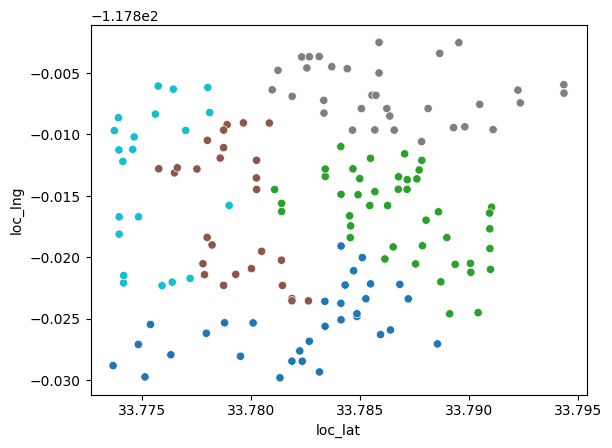

K-means takes 0:00:06.070561


In [29]:
k_start_time = datetime.now()
k_solver = ClusterSolver(package_data, param_cluster_ngen)
k_solver.run()
package_assignment = k_solver.get_assignment()
k_duration = datetime.now() - k_start_time
print('K-means takes ' + str(k_duration))

### Experiment 1: Genetic Algorithm Only

Genetic algorithm parameters:

In [30]:
param_ngen = 1000
param_size_of_population = 100
param_mut_prob = 0.3
param_cro_prob = 0.7

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 427087.9999999999
Route: [[104, 97, 106, 49, 70, 25, 48, 126, 50, 77, 64, 93, 120, 124, 81, 102, 67, 88, 14, 109, 9, 65, 121, 51, 15, 142, 39, 63, 40], [118, 151, 78, 133, 137, 43, 87, 73, 47, 119, 11, 46, 136, 154, 3, 105, 53, 114, 107, 143, 95, 101, 139, 18, 38, 134, 127, 58, 112, 66, 86, 21, 31, 22, 13, 83, 90, 148, 131, 69], [62, 110, 98, 10, 85, 132, 111, 4, 156, 34, 123, 5, 94, 33, 128, 30, 116, 74, 29, 100, 141, 68], [17, 91, 82, 96, 89, 54, 108, 125, 44, 103, 129, 42, 8, 28, 35, 92, 72, 2, 135, 36, 140, 23, 37, 84, 146, 130, 113, 75, 19, 138, 61, 122, 1, 155, 26], [80, 52, 0, 16, 153, 12, 152, 45, 55, 6, 99, 115, 57, 20, 59, 7, 32, 79, 24, 71, 60, 76, 41, 117, 27, 56, 145, 144, 150, 149, 147]]


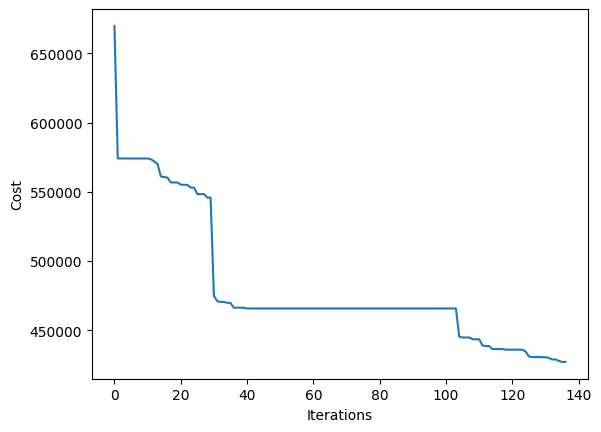

In [31]:
gene_solver = GeneSolver(True,
                         package_data,
                         param_size_of_population,
                         param_ngen,
                         param_unit_cost,
                         param_wait_cost,
                         param_delay_cost,
                         param_vehicle_capacity,
                         param_work_time,
                         param_depot,
                         param_mut_prob,
                         param_cro_prob,
                         test_duration
                         )
result = gene_solver.run_solver()
reschedule_data = result['route']
cost_iter=[result["best"]]
visualization_cost(result['best'])

Result and visualization:

Total cost: 427087.9999999999


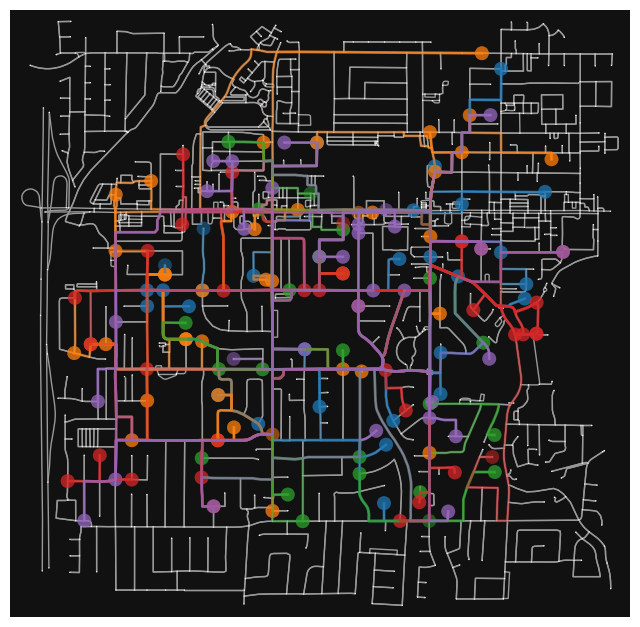

In [32]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], False)

### Experiment 2: K-means Clustering and Genetic Algorithm Hybrid

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 48471.99999999999
Route: [[15, 25, 5, 13, 3, 23, 17, 16, 9, 12, 21, 2, 14, 8, 4, 19, 0, 20, 6, 26, 18, 7, 24, 22, 10, 1, 11]]
Cost: 51620.79999999998
Route: [[32, 4, 19, 11, 25, 31, 10, 20, 14, 26, 18, 22, 21, 0, 28, 3, 6, 5, 30, 24, 33, 7, 9, 23, 13, 27, 15, 16, 17, 8, 29, 1, 12, 2]]
Cost: 49150.39999999999
Route: [[3, 4, 16, 14, 17, 9, 11, 15, 20, 0, 18, 10, 13, 5, 2, 19, 6, 7, 1, 12, 8]]
Cost: 247512.10000000003
Route: [[8, 17, 1, 24, 7, 38, 42, 9, 33, 40, 12, 41, 13, 2, 5, 22, 21, 32, 3, 20, 27, 19, 14, 23, 6, 28, 11, 29, 4, 25, 0, 31, 30, 16, 39, 34, 26, 15, 18, 36, 35, 10, 37]]
Cost: 52662.40000000001
Route: [[1, 24, 20, 23, 10, 8, 9, 12, 6, 26, 31, 27, 7, 29, 17, 2, 19, 5, 21, 16, 30, 22, 3, 28, 18, 14, 25, 4, 15, 13, 0, 11]]


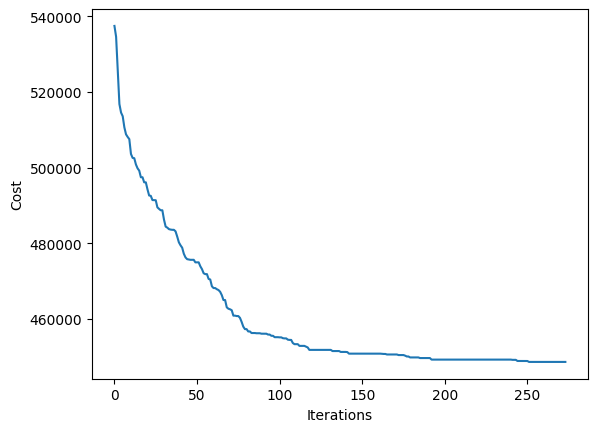

In [33]:
result = {'cost': 0, 'route': [], 'df':[], 'best': []}
futures = []
with ThreadPoolExecutor(max_workers=len(package_assignment)) as executor:
    for route in package_assignment:
        gene_solver = GeneSolver(False,
                                 route,
                                 param_size_of_population,
                                 param_ngen,
                                 param_unit_cost,
                                 param_wait_cost,
                                 param_delay_cost,
                                 param_vehicle_capacity,
                                 param_work_time,
                                 param_depot,
                                 param_mut_prob,
                                 param_cro_prob,
                                 test_duration - k_duration.total_seconds()
                                 )
        futures.append(executor.submit(gene_solver.run_solver))
    for future in as_completed(futures):
        result['cost'] += future.result()['cost']
        result['route'] += future.result()['route']
        result['df'].append(future.result()['df'])
        result['best'].append(future.result()['best'])
result['best'] = sum_best(result['best'])
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

Total cost: 449417.7


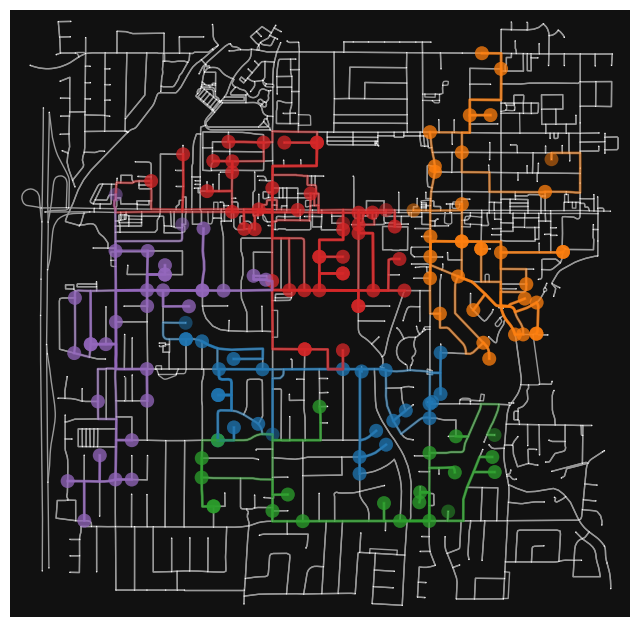

In [34]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], True)

### Experiment 3: Adaptive Genetic Algorithm Only

In [ ]:
gene_solver = AGeneSolver(True,
                         package_data,
                         param_size_of_population,
                         param_ngen,
                         param_unit_cost,
                         param_wait_cost,
                         param_delay_cost,
                         param_vehicle_capacity,
                         param_work_time,
                         param_depot,
                         param_mut_prob,
                         param_cro_prob,
                         test_duration
                         )
result = gene_solver.run_solver()
reschedule_data = result['route']
cost_iter=[result["best"]]
visualization_cost(result['best'])

Result and visualization:

In [ ]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], False)

### Experiment 4: K-means Clustering and Adaptive Genetic Algorithm Hybrid

In [ ]:
result = {'cost': 0, 'route': [], 'df':[], 'best': []}
futures = []
with ThreadPoolExecutor(max_workers=len(package_assignment)) as executor:
    for route in package_assignment:
        gene_solver = AGeneSolver(False,
                                 route,
                                 param_size_of_population,
                                 param_ngen,
                                 param_unit_cost,
                                 param_wait_cost,
                                 param_delay_cost,
                                 param_vehicle_capacity,
                                 param_work_time,
                                 param_depot,
                                 param_mut_prob,
                                 param_cro_prob,
                                 test_duration - k_duration.total_seconds()
                                 )
        futures.append(executor.submit(gene_solver.run_solver))
    for future in as_completed(futures):
        result['cost'] += future.result()['cost']
        result['route'] += future.result()['route']
        result['df'].append(future.result()['df'])
        result['best'].append(future.result()['best'])
result['best'] = sum_best(result['best'])
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

In [ ]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], True)

### Experiment 5: ACO Algorithm Only

ACO algorithm parameters:

In [35]:
param_ngen = 1000
param_n_ant = 100
param_alpha = 1
param_beta = 5
param_rho = 0.10
param_Q = 800

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 347766.55000000005
Route: [[151, 99, 4, 23, 108, 16, 118, 43, 55, 24, 44, 79, 117, 106, 33, 93, 78, 28, 8, 14, 60, 125, 42, 112, 100, 52, 88, 65, 111, 76, 127, 41, 12, 50, 82, 19, 148, 101, 123, 57, 124, 10, 132, 47, 97, 146, 67], [84, 116, 130, 7, 6, 92, 72, 27, 96, 153, 59, 38, 113, 136, 155, 63, 142, 22, 39, 40, 89, 121, 152, 53, 139, 66, 2, 149, 156, 29, 26], [147, 11, 115, 9, 58, 109, 90, 133, 45, 105, 48, 15, 137, 83, 51, 120, 36, 35, 140, 103, 77, 64, 91, 0, 129, 30, 122, 128, 62, 61, 138, 25, 74, 94, 46, 69], [119, 134, 85, 143, 31, 18, 80, 70, 154, 107, 104, 21, 1, 54, 86, 135, 3, 144, 75, 56, 145, 141, 114, 20, 13, 81, 150, 34], [87, 49, 37, 131, 73, 95, 126, 32, 110, 5, 102, 71, 98, 17, 68]]


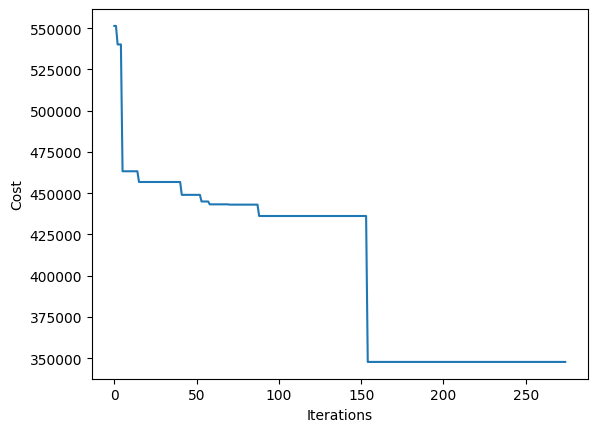

In [36]:
aco_solver = ACOSolver(True,
                       package_data,
                       param_n_ant,
                       param_ngen,
                       param_unit_cost,
                       param_wait_cost,
                       param_delay_cost,
                       param_vehicle_capacity,
                       param_work_time,
                       param_depot,
                       param_alpha,
                       param_beta,
                       param_rho,
                       param_Q,
                       test_duration
                       )
result = aco_solver.run_solver()
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

Total cost: 347766.55000000005


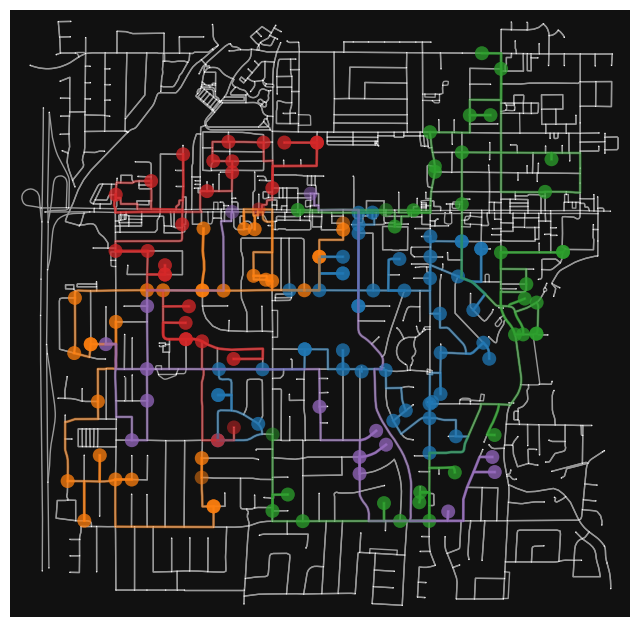

In [37]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], False)

### Experiment 6: K-means Clustering and ACO Algorithm Hybrid

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 47916.799999999996
Route: [[11, 0, 3, 23, 30, 22, 10, 13, 28, 4, 8, 9, 18, 25, 14, 15, 31, 27, 7, 24, 20, 12, 19, 16, 21, 5, 2, 17, 26, 6, 29, 1]]
Cost: 47302.39999999998
Route: [[15, 25, 5, 3, 13, 10, 22, 24, 17, 7, 23, 1, 18, 26, 4, 8, 14, 2, 21, 12, 9, 16, 19, 0, 20, 6, 11]]
Cost: 47852.00000000001
Route: [[20, 10, 13, 18, 0, 5, 9, 11, 15, 2, 6, 19, 7, 16, 4, 14, 17, 8, 1, 12, 3]]
Cost: 46600.00000000001
Route: [[0, 21, 16, 17, 30, 33, 24, 7, 8, 28, 9, 15, 29, 5, 1, 3, 27, 23, 13, 22, 6, 18, 2, 12, 19, 26, 14, 20, 31, 10, 25, 11, 4, 32]]
Cost: 237321.9
Route: [[2, 17, 8, 9, 42, 38, 40, 23, 0, 19, 28, 24, 6, 25, 7, 12, 30, 16, 31, 33, 13, 41, 1, 5, 26, 34, 36, 15, 18, 35, 21, 32, 22, 3, 20, 39, 10, 27, 11, 29, 14, 4, 37]]


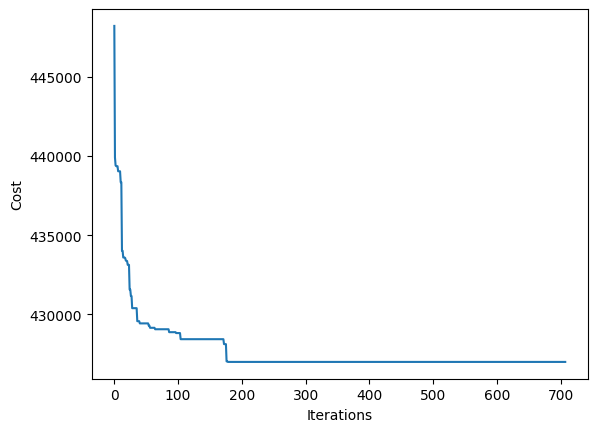

In [38]:
result = {'cost': 0, 'route': [], 'df':[], 'best': []}
futures = []
with ThreadPoolExecutor(max_workers=len(package_assignment)) as executor:
    for route in package_assignment:
        aco_solver = ACOSolver(False,
                               route,
                               param_n_ant,
                               param_ngen,
                               param_unit_cost,
                               param_wait_cost,
                               param_delay_cost,
                               param_vehicle_capacity,
                               param_work_time,
                               param_depot,
                               param_alpha,
                               param_beta,
                               param_rho,
                               param_Q,
                               test_duration - k_duration.total_seconds()
                               )
        futures.append(executor.submit(aco_solver.run_solver))
    for future in as_completed(futures):
        result['cost'] += future.result()['cost']
        result['route'] += future.result()['route']
        result['df'].append(future.result()['df'])
        result['best'].append(future.result()['best'])
result['best'] = sum_best(result['best'])
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

Total cost: 426993.1


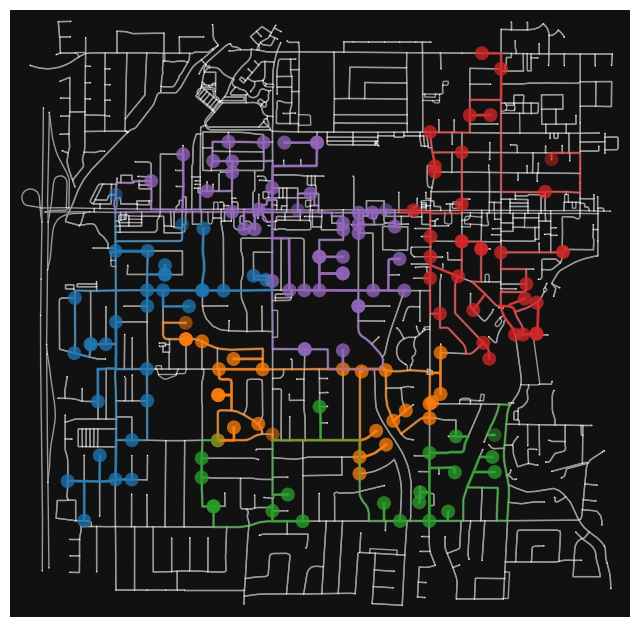

In [39]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], True)

### Experiment 7: H-ACO Algorithm Only

Parameters:

In [40]:
param_ngen = 1000
param_n_ant = 100
param_alpha = 1
param_beta = 5
param_rho = 0.1
param_Q = 800

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 358926.55000000005
Route: [[19, 50, 82, 12, 111, 76, 127, 62, 128, 25, 138, 61, 71, 5, 102, 110, 32, 126, 101, 123, 57, 124, 69], [10, 132, 47, 97, 46, 74, 94, 119, 146, 67, 84, 116, 31, 143, 18, 70, 63, 142, 22, 39, 40, 89, 66, 139, 53, 152, 121, 87, 34, 28, 8, 14, 125, 60], [51, 83, 109, 58, 90, 133, 45, 105, 48, 15, 137, 91, 0, 64, 129, 88, 65, 100, 52, 112, 42, 120, 36, 35, 140, 103, 77, 33, 93, 78, 9, 115, 118, 43, 55, 16, 24, 44, 23, 108, 117, 106, 79, 2, 149, 151, 99, 29, 26], [147, 11, 20, 114, 141, 145, 56, 75, 144, 54, 1, 21, 154, 107, 104, 73, 131, 37, 153, 38, 113, 59, 49, 85, 80, 136, 155, 135, 86, 3, 6, 92, 27, 96], [72, 130, 7, 4, 156, 148, 95, 134, 30, 41, 122, 98, 17, 150, 81, 13, 68]]


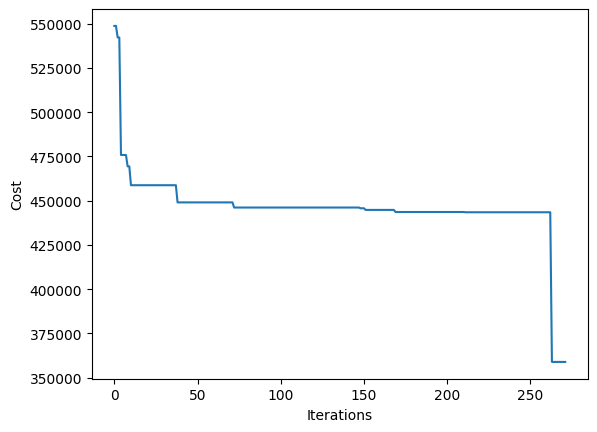

In [41]:
haco_solver = HACOSolver(True,
                         package_data,
                         param_n_ant,
                         param_ngen,
                         param_unit_cost,
                         param_wait_cost,
                         param_delay_cost,
                         param_vehicle_capacity,
                         param_work_time,
                         param_depot,
                         param_alpha,
                         param_beta,
                         param_rho,
                         param_Q,
                         test_duration
                         )
result = haco_solver.run_solver()
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

Total cost: 358926.55000000005


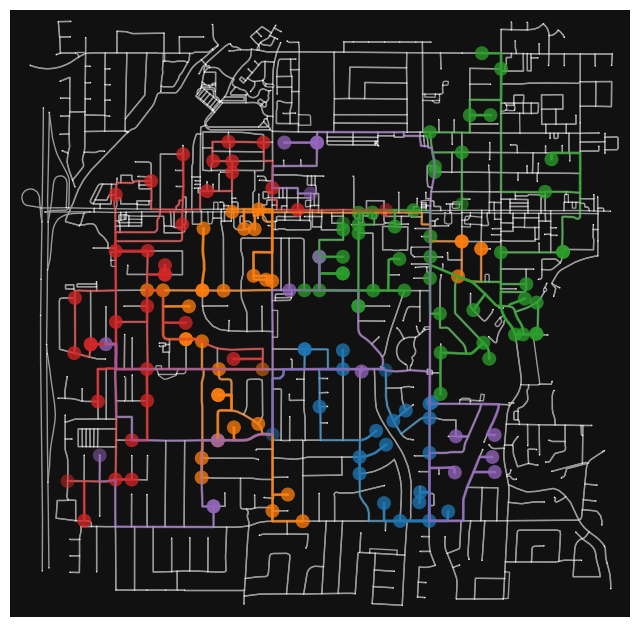

In [42]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], False)

### Experiment 8: K-means Clustering and H-ACO Algorithm Hybrid

Solver definition:

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 47076.0
Route: [[20, 13, 10, 0, 18, 5, 9, 11, 15, 4, 16, 14, 17, 2, 19, 6, 7, 8, 1, 12, 3]]
Cost: 46723.19999999998
Route: [[21, 0, 16, 17, 30, 33, 24, 7, 8, 28, 9, 27, 23, 13, 3, 15, 29, 22, 6, 18, 5, 1, 12, 2, 14, 26, 20, 19, 31, 10, 25, 11, 4, 32]]
Cost: 47351.2
Route: [[1, 3, 22, 30, 23, 10, 13, 28, 4, 8, 9, 18, 25, 14, 15, 31, 27, 7, 24, 20, 29, 21, 5, 16, 19, 2, 17, 26, 6, 12, 0, 11]]
Cost: 47089.600000000006
Route: [[15, 25, 5, 3, 13, 1, 23, 7, 17, 24, 10, 22, 6, 19, 0, 20, 26, 4, 8, 14, 2, 12, 21, 16, 9, 18, 11]]
Cost: 238750.85000000003
Route: [[17, 2, 8, 9, 42, 38, 40, 23, 0, 25, 4, 14, 11, 29, 27, 6, 10, 33, 13, 41, 5, 39, 20, 3, 26, 34, 36, 15, 18, 22, 35, 21, 32, 31, 16, 30, 12, 7, 19, 28, 24, 1, 37]]


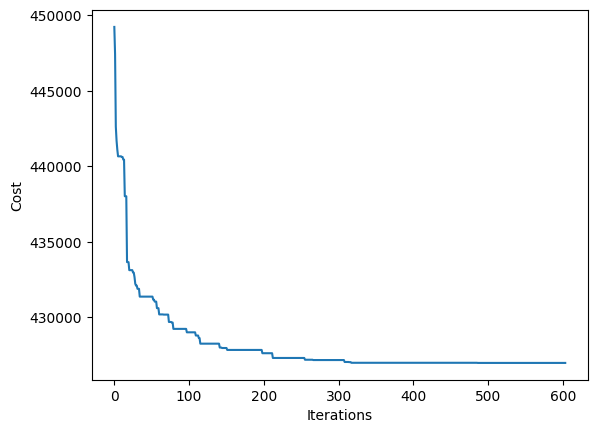

In [43]:
result = {'cost': 0, 'route': [], 'df': [], 'best': []}
futures = []
with ThreadPoolExecutor(max_workers=len(package_assignment)) as executor:
    for route in package_assignment:
        haco_solver = HACOSolver(False,
                                 route,
                                 param_n_ant,
                                 param_ngen,
                                 param_unit_cost,
                                 param_wait_cost,
                                 param_delay_cost,
                                 param_vehicle_capacity,
                                 param_work_time,
                                 param_depot,
                                 param_alpha,
                                 param_beta,
                                 param_rho,
                                 param_Q,
                                 test_duration - k_duration.total_seconds()
                               )
        futures.append(executor.submit(haco_solver.run_solver))
    for future in as_completed(futures):
        result['cost'] += future.result()['cost']
        result['route'] += future.result()['route']
        result['df'].append(future.result()['df'])
        result['best'].append(future.result()['best'])
result['best'] = sum_best(result['best'])
cost_iter.append(result["best"])
visualization_cost(result['best'])

Result and visualization:

Total cost: 426990.85


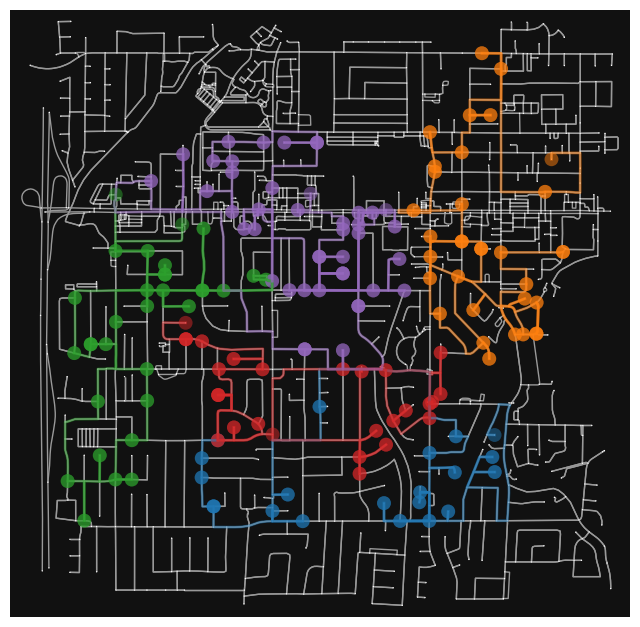

In [44]:
print('Total cost: ' + str(result['cost']))
visualization(result['route'], result['df'], True)

### Experiment 9: Rescheduling Algorithm

In [49]:
#original route
route = [reschedule_data[0]]

# Pick the one package as the one that vehicle failed to deliver and reschedule the remaining route
index = len(route[0])//2

res, remain_route = reschedule(route[0], package_data, route[0][index], 8, 0.5, 1.5, 3*60*60, "FJ")

print("Able to reschedule? "+str(res))
if res:
    route_re = []
    route_re.append(route[0][:index+1])
    route_re.append(remain_route)
    print("package delivered again: "+str(route_re[0][-1]))
    print(route_re)

Able to reschedule? True
package delivered again: 81
[[104, 97, 106, 49, 70, 25, 48, 126, 50, 77, 64, 93, 120, 124, 81], [102, 67, 88, 14, 109, 9, 65, 121, 51, 15, 81, 142, 39, 63, 40]]


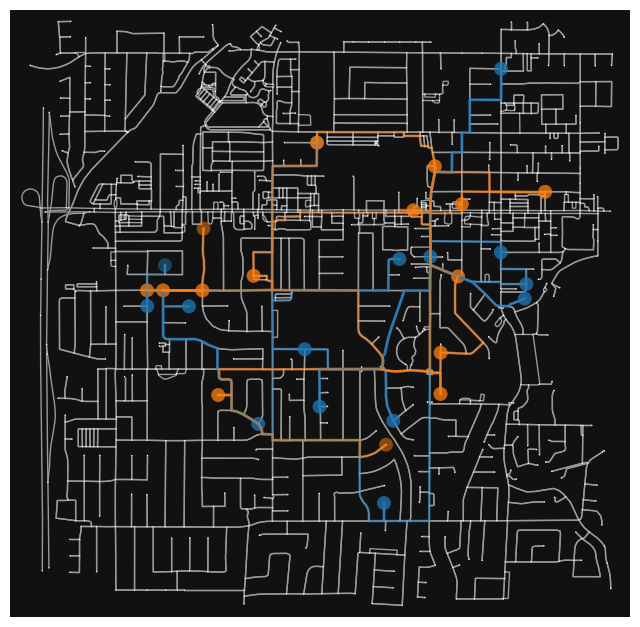

In [50]:
if res:
    #Draw reschedule route (blue: original route before re-deliver package, orange: recheduled remaining route)
    visualization(route_re, package_data, False)

### Overall Cost Versus Time Graph

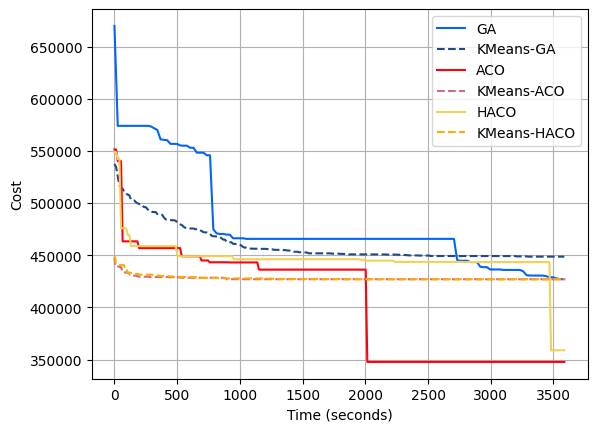

In [47]:
names = ["GA", "KMeans-GA", "AGA", "KMeans-AGA" "ACO", "KMeans-ACO", "HACO", "KMeans-HACO"]
color = ['xkcd:bright blue', 'xkcd:cobalt', 'xkcd: green', 'xkcd: lime green' ,'xkcd:bright red',  'xkcd:pinkish', 'xkcd:maize', 'xkcd:orange yellow']
style = ['-', '--', '-', '--', '-', '--', '-', '--']

for i in range(len(cost_iter)):
    x=[j*test_duration/len(cost_iter[i]) for j in range(len(cost_iter[i]))]
    y=[1/k for k in cost_iter[i]]
    plt.plot(x, y, color=color[i], label=names[i], linestyle=style[i])
plt.xlabel("Time (seconds)")
plt.ylabel("Cost")
plt.legend()
plt.grid()
plt.show()

## References

[1] T. Qu, "py-ga-VRPTW," https://github.com/iRB-Lab/py-ga-VRPTW, accessed: Dec. 08, 2022. <br>
[2] A. Khamis and Y. Wang, "Genetic Algorithms," https://smartmobilityalgorithms.github.io/book/content/EvolutionaryComputingAlgorithms/GeneticAlgorithms.html?highlight=genetic, accessed: Dec. 08, 2022. <br>
[3] Junyi118, "Ant Colony Algorithm--python," https://github.com/junyi118/-/blob/master/%E8%9A%81%E7%BE%A4%E7%AE%97%E6%B3%95python%E5%AE%9E%E7%8E%B0, accessed: Dec. 08, 2022. <br>
[4] L. J. Zheng, D. C. Dong and D. Y. Wang, "A hybrid intelligent algorithm for the vehicle scheduling problems with time windows," 17th International IEEE Conference on Intelligent Transportation Systems (ITSC), 2014, pp. 2756-2761, doi: 10.1109/ITSC.2014.6958131.

## Dependencies

Our experiment environment is configured with the following packages: <br>

| Package Name             | Version      |
|--------------------------|--------------|
| pandas                   | 1.5.1        |
| seaborn                  | 0.11.2       |
| numpy                    | 1.22.0       |
| json                     | 2.0.9        |
| matplotlib               | 3.6.2        |
| osmnx                    | 1.2.2        |
| scikit-learn             | 0.24.2       |
| smart_mobility_utilities | 0.0.10       |
| folium                   | 0.12.1.post1 |

The environment satisfaction can be checked by running the code cell below.


In [48]:
print(watermark(iversions=True, globals_=globals()))

json      : 2.0.9
folium    : 0.13.0
numpy     : 1.23.3
osmnx     : 1.2.2
pandas    : 1.5.0
matplotlib: 3.6.2

